Importing Required Libraries


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


Importing Data

In [ ]:
train_normal_path = '/content/drive/MyDrive/CANCER_DATASET/train/train/normal'
train_tumor_path = '/content/drive/MyDrive/CANCER_DATASET/train/train/pancreatic_tumor'
test_normal_path = '/content/drive/MyDrive/CANCER_DATASET/test/test/normal'
test_tumor_path = '/content/drive/MyDrive/CANCER_DATASET/test/test/pancreatic_tumor'

Defining Images as Normal and Tumor images followed by train and test for the model

In [ ]:

def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        img_bgr = cv2.imread(file_path)
        if img_bgr is not None:
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            images.append(img_rgb)
            labels.append(label)
    return images, labels

train_normal_images, train_normal_labels = load_images_from_folder(train_normal_path, label=0)
train_tumor_images, train_tumor_labels = load_images_from_folder(train_tumor_path, label=1)

X_train = train_normal_images + train_tumor_images
y_train = train_normal_labels + train_tumor_labels

print(f"Train: Loaded {len(X_train)} images total.")

test_normal_images, test_normal_labels = load_images_from_folder(test_normal_path, label=0)
test_tumor_images, test_tumor_labels = load_images_from_folder(test_tumor_path, label=1)

X_test = test_normal_images + test_tumor_images
y_test = test_normal_labels + test_tumor_labels

print(f"Test: Loaded {len(X_test)} images total.")


Train: Loaded 1007 images total.
Test: Loaded 412 images total.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Extracting ROI with Laplacian


In [ ]:
def extract_roi(image, target_size=(128, 128), lap_threshold=30):
    image_resized = cv2.resize(image, target_size)
    gray = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY)

    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    laplacian = np.uint8(np.absolute(laplacian))

    _, thresh = cv2.threshold(laplacian, lap_threshold, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        roi = image_resized[y:y+h, x:x+w]
        roi = cv2.resize(roi, target_size)
        return roi
    else:
        return image_resized


In [ ]:
def preprocess_images(images, target_size=(128, 128)):
    processed = []
    for img in images:
        roi_img = extract_roi(img, target_size=target_size)
        processed.append(roi_img)
    return np.array(processed)

X_train_processed = preprocess_images(X_train, (128, 128))
X_test_processed = preprocess_images(X_test, (128, 128))


X_train_processed = X_train_processed.astype('float32') / 255.0
X_test_processed = X_test_processed.astype('float32') / 255.0

y_train = np.array(y_train)
y_test = np.array(y_test)

print("Shapes after preprocessing:")
print("X_train_processed:", X_train_processed.shape)
print("y_train:", y_train.shape)
print("X_test_processed:", X_test_processed.shape)
print("y_test:", y_test.shape)


Shapes after preprocessing:
X_train_processed: (1007, 128, 128, 3)
y_train: (1007,)
X_test_processed: (412, 128, 128, 3)
y_test: (412,)


In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator()

from sklearn.model_selection import train_test_split
X_train_aug, X_val, y_train_aug, y_val = train_test_split(X_train_processed, y_train, test_size=0.2, random_state=42)

batch_size = 16

train_generator = train_datagen.flow(X_train_aug, y_train_aug, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)


Classification model 1

In [ ]:
input_shape = (128, 128, 3)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

classification_model = Model(inputs=base_model.input, outputs=predictions)


classification_model.compile(optimizer=Adam(learning_rate=1e-4),
                             loss='binary_crossentropy',
                             metrics=['accuracy'])

classification_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 128, 128,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 128, 128,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 128, 128,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 4,008,829 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)
checkpoint = ModelCheckpoint('best_classification_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

callbacks_list = [earlystop, reduce_lr, checkpoint]


In [ ]:
epochs = 20

history = classification_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks_list
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7908 - loss: 0.4396
Epoch 1: val_loss improved from inf to 0.76409, saving model to best_classification_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.7929 - loss: 0.4365 - val_accuracy: 0.4257 - val_loss: 0.7641 - learning_rate: 1.0000e-04
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9710 - loss: 0.1116
Epoch 2: val_loss did not improve from 0.76409
51/51 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9709 - loss: 0.1117 - val_accuracy: 0.4257 - val_loss: 0.9559 - learning_rate: 1.0000e-04
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9655 - loss: 0.0871
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 3: val_loss did not improve from 0.76409
51/51 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9656 - loss: 0.0870 - val_accuracy: 0.4257 - val_loss: 0.9161 - learning_rate: 1.0000e-04
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9647 - loss: 0.0816
Epoch 4: val_loss did not improve from 0.76409
51/51 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9647 - loss: 0.0816 - val_accuracy: 0.4257 - val_l

Great training accuray , lower val accuracy

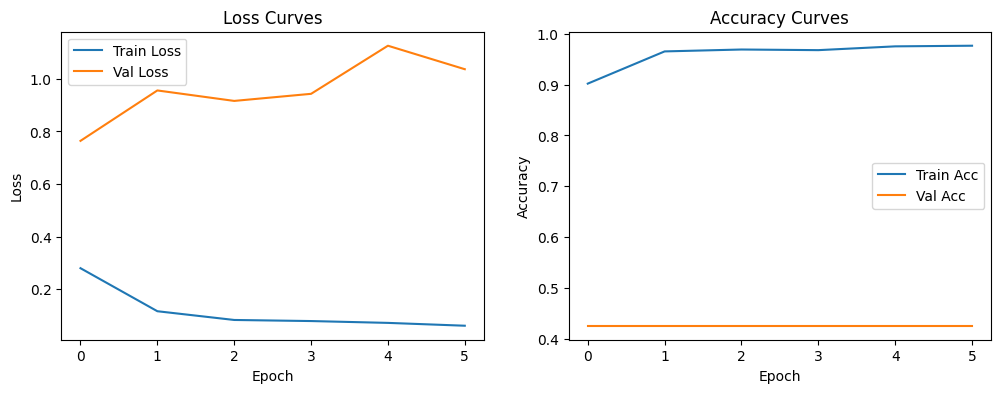

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.show()


Using Data augmentation for better Classification model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


classification Model 2

In [ ]:
input_shape = (128, 128, 3)
inputs = Input(shape=input_shape)

x = data_augmentation(inputs)

base_model = EfficientNetB0(weights="imagenet", include_top=False, input_tensor=x)
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

classification_model = Model(inputs, outputs)

classification_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

classification_model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 128, 128,  │          0 │ input_layer_3[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 128, 128,  │          0 │ sequential_1[0][… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 128, 128,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 128, 128,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = classification_model.fit(
    X_train_processed, y_train,
    validation_data=(X_test_processed, y_test),
    epochs=30,
    batch_size=8,
    callbacks=[early_stop, lr_reduce]
)


Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 51s 296ms/step - accuracy: 0.5221 - loss: 0.7154 - val_accuracy: 0.4539 - val_loss: 0.7276 - learning_rate: 1.0000e-04
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 244ms/step - accuracy: 0.5551 - loss: 0.7105 - val_accuracy: 0.4539 - val_loss: 0.7208 - learning_rate: 1.0000e-04
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 44s 266ms/step - accuracy: 0.5251 - loss: 0.7073 - val_accuracy: 0.4539 - val_loss: 0.7161 - learning_rate: 1.0000e-04
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 265ms/step - accuracy: 0.5016 - loss: 0.7116 - val_accuracy: 0.4539 - val_loss: 0.7216 - learning_rate: 1.0000e-04
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 270ms/step - accuracy: 0.5393 - loss: 0.6975 - val_accuracy: 0.4539 - val_loss: 0.7180 - learning_rate: 1.0000e-04
Epoch 6/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 40s 264ms/step - accuracy: 0.5648 - loss: 0.6955 - val_accuracy: 0.4539 - val_loss: 0.7193 - learning_rate: 1.0000e-04
Epoch 7/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 38s 24

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False
classification_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_ft = classification_model.fit(
    X_train_processed, y_train,
    validation_data=(X_test_processed, y_test),
    epochs=15,
    batch_size=8,
    callbacks=[early_stop, lr_reduce]
)


Epoch 1/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 61s 332ms/step - accuracy: 0.5305 - loss: 0.7025 - val_accuracy: 0.4539 - val_loss: 0.6989 - learning_rate: 1.0000e-05
Epoch 2/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 75s 281ms/step - accuracy: 0.5743 - loss: 0.6728 - val_accuracy: 0.4539 - val_loss: 0.6958 - learning_rate: 1.0000e-05
Epoch 3/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 44s 304ms/step - accuracy: 0.5874 - loss: 0.6804 - val_accuracy: 0.4539 - val_loss: 0.6969 - learning_rate: 1.0000e-05
Epoch 4/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 275ms/step - accuracy: 0.6083 - loss: 0.6630 - val_accuracy: 0.4539 - val_loss: 0.6671 - learning_rate: 1.0000e-05
Epoch 5/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 44s 302ms/step - accuracy: 0.6233 - loss: 0.6734 - val_accuracy: 0.4539 - val_loss: 0.6843 - learning_rate: 1.0000e-05
Epoch 6/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 38s 303ms/step - accuracy: 0.6172 - loss: 0.6544 - val_accuracy: 0.4539 - val_loss: 0.6470 - learning_rate: 1.0000e-05
Epoch 7/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 40s 29

Poor accuracies for class model 2


Defining classification model 3

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

input_shape = (128, 128, 3)
inputs = Input(shape=input_shape)

x = data_augmentation(inputs)

base_model = EfficientNetB0(weights="imagenet", include_top=False, input_tensor=x)
base_model.trainable = True

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)

classification_model = Model(inputs, outputs)

classification_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

classification_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ sequential[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 4,008,829 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = classification_model.fit(
    X_train_processed, y_train,
    validation_data=(X_test_processed, y_test),
    epochs=25,
    batch_size=8,
    callbacks=[early_stop, lr_reduce]
)


Epoch 1/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 67s 140ms/step - accuracy: 0.8542 - loss: 0.3570 - val_accuracy: 0.4539 - val_loss: 0.8065 - learning_rate: 1.0000e-04
Epoch 2/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.9595 - loss: 0.1328 - val_accuracy: 0.7670 - val_loss: 0.6299 - learning_rate: 1.0000e-04
Epoch 3/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.9629 - loss: 0.0989 - val_accuracy: 0.5461 - val_loss: 1.0044 - learning_rate: 1.0000e-04
Epoch 4/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.9786 - loss: 0.0576 - val_accuracy: 0.5461 - val_loss: 1.1125 - learning_rate: 1.0000e-04
Epoch 5/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - accuracy: 0.9839 - loss: 0.0506 - val_accuracy: 0.5461 - val_loss: 1.0007 - learning_rate: 1.0000e-04
Epoch 6/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.9575 - loss: 0.0779 - val_accuracy: 0.7888 - val_loss: 0.4297 - learning_rate: 5.0000e-05
Epoch 7/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/st

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

classification_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_ft = classification_model.fit(
    X_train_processed, y_train,
    validation_data=(X_test_processed, y_test),
    epochs=15,
    batch_size=8,
    callbacks=[early_stop, lr_reduce]
)


Epoch 1/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.8526 - loss: 0.3748 - val_accuracy: 0.9757 - val_loss: 0.2991 - learning_rate: 1.0000e-05
Epoch 2/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8543 - loss: 0.3500 - val_accuracy: 0.9903 - val_loss: 0.3158 - learning_rate: 1.0000e-05
Epoch 3/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8768 - loss: 0.3130 - val_accuracy: 0.9903 - val_loss: 0.3295 - learning_rate: 1.0000e-05
Epoch 4/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8542 - loss: 0.2947 - val_accuracy: 0.9854 - val_loss: 0.2912 - learning_rate: 1.0000e-05
Epoch 5/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9098 - loss: 0.2662 - val_accuracy: 0.9903 - val_loss: 0.3192 - learning_rate: 1.0000e-05
Epoch 6/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9069 - loss: 0.2822 - val_accuracy: 0.9903 - val_loss: 0.2706 - learning_rate: 1.0000e-05
Epoch 7/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - ac

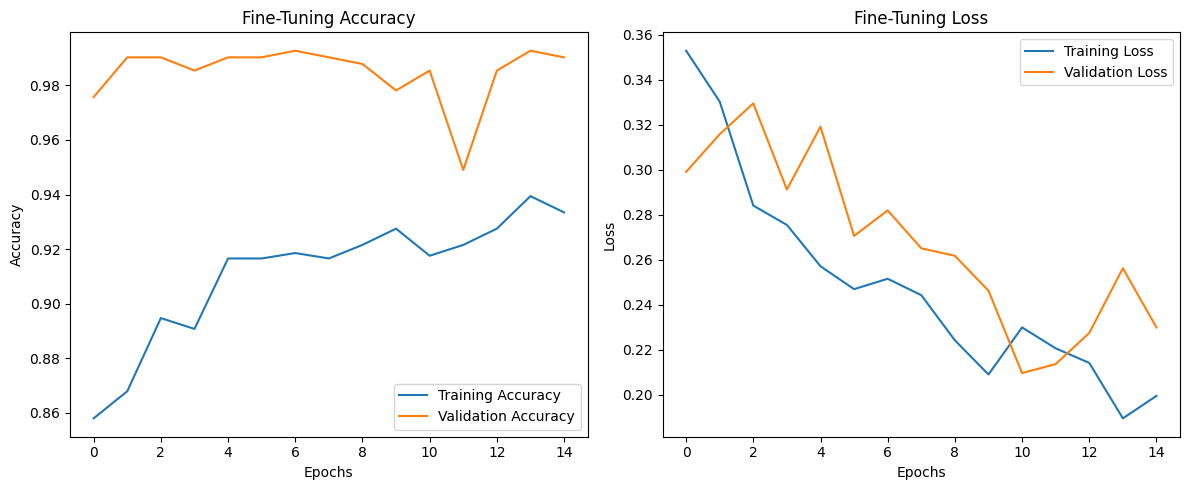

In [ ]:
import matplotlib.pyplot as plt

acc = history_ft.history['accuracy']
val_acc = history_ft.history['val_accuracy']
loss = history_ft.history['loss']
val_loss = history_ft.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Fine-Tuning Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Fine-Tuning Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Great accuracy in both training and validation

Since there is no highlighted data on the tumor, making an artificial mask to segment the tumor

defining a Gradcam heatmap and a pseudo mask !

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    import tensorflow as tf

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()


In [ ]:
import cv2

def smooth_and_threshold_heatmap(heatmap, threshold_value=0.7, blur_ksize=(5,5)):

    heatmap_blurred = cv2.GaussianBlur(heatmap, blur_ksize, 0)
    pseudo_mask = (heatmap_blurred > threshold_value).astype(np.float32)
    return pseudo_mask


In [ ]:
pseudo_masks = []
threshold_value = 0.6

for img, label in zip(X_train_processed, y_train):
    if label == 1:
        img_input = np.expand_dims(img, axis=0)
        heatmap = make_gradcam_heatmap(img_input, classification_model, last_conv_layer_name="top_conv")
        heatmap_resized = cv2.resize(heatmap, (128, 128))
        pseudo_mask = (heatmap_resized > threshold_value).astype(np.float32)
    else:
        pseudo_mask = np.zeros((128, 128), dtype=np.float32)
    pseudo_masks.append(pseudo_mask)
pseudo_mask = smooth_and_threshold_heatmap(heatmap_resized, threshold_value=0.7)

pseudo_masks = np.array(pseudo_masks)
print("Pseudo masks shape:", pseudo_masks.shape)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


Pseudo masks shape: (1007, 128, 128)


In [ ]:
def refine_mask(mask, kernel_size=3):
    mask_uint8 = (mask * 255).astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

    closed = cv2.morphologyEx(mask_uint8, cv2.MORPH_CLOSE, kernel)
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)

    refined_mask = (opened.astype(np.float32) / 255.0)
    return refined_mask


Defining the UNet segementation model 1

In [ ]:
def unet_model(input_size=(128, 128, 3)):
    from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout
    from tensorflow.keras.models import Model

    inputs = Input(input_size)

    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = UpSampling2D(size=(2, 2))(drop5)
    up6 = Conv2D(512, 2, activation='relu', padding='same')(up6)
    merge6 = Concatenate()([drop4, up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same')(up7)
    merge7 = Concatenate()([conv3, up7])
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same')(up8)
    merge8 = Concatenate()([conv2, up8])
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same')(up9)
    merge9 = Concatenate()([conv1, up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    return model

segmentation_model = unet_model(input_size=(128, 128, 3))
segmentation_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                           loss='binary_crossentropy',
                           metrics=['accuracy'])
segmentation_model.summary()


Model: "functional_581"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 8, 8,      │          0 │ conv2d_9[0][0]  

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_seg = segmentation_model.fit(
    X_train_processed, pseudo_masks,
    validation_split=0.1,
    epochs=20,
    batch_size=8,
    callbacks=[early_stop, lr_reduce]
)


Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 91s 488ms/step - accuracy: 0.8411 - loss: 0.5199 - val_accuracy: 0.7261 - val_loss: 0.4746 - learning_rate: 1.0000e-04
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 79s 176ms/step - accuracy: 0.8749 - loss: 0.2135 - val_accuracy: 0.8892 - val_loss: 0.5026 - learning_rate: 1.0000e-04
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step - accuracy: 0.9580 - loss: 0.0974 - val_accuracy: 0.9035 - val_loss: 0.4655 - learning_rate: 1.0000e-04
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - accuracy: 0.9617 - loss: 0.0899 - val_accuracy: 0.9106 - val_loss: 0.4650 - learning_rate: 1.0000e-04
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - accuracy: 0.9588 - loss: 0.0951 - val_accuracy: 0.9146 - val_loss: 0.4436 - learning_rate: 1.0000e-04
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - accuracy: 0.9632 - loss: 0.0826 - val_accuracy: 0.9045 - val_loss: 0.4856 - learning_rate: 1.0000e-04
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 21s 17

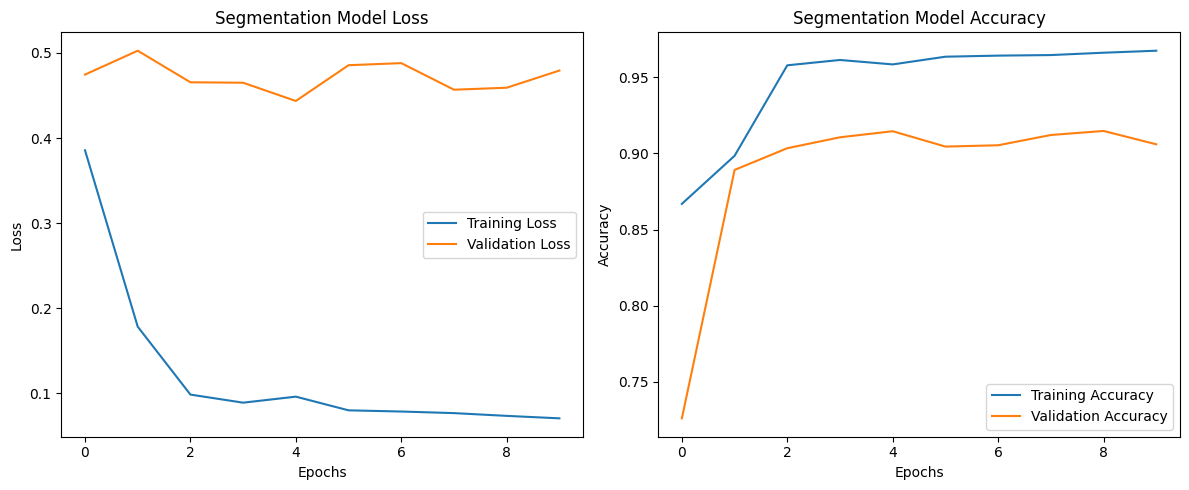

In [ ]:
import matplotlib.pyplot as plt

loss = history_seg.history['loss']
val_loss = history_seg.history['val_loss']
acc = history_seg.history['accuracy']
val_acc = history_seg.history['val_accuracy']
epochs_range = range(len(loss))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Segmentation Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Segmentation Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


To mark the region of tumor


In [ ]:
def draw_segmentation_contours(original_img, mask, contour_color=(255, 0, 0), thickness=2):
    h, w, _ = original_img.shape
    mask_resized = cv2.resize(mask, (w, h))
    mask_uint8 = (mask_resized * 255).astype(np.uint8)
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    image_bgr = cv2.cvtColor(original_img.copy(), cv2.COLOR_RGB2BGR)
    cv2.drawContours(image_bgr, contours, -1, contour_color, thickness)
    overlayed = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    return overlayed

selecting a random image from data and marking down the tumor

Produces a refined segmentation output by post-processing the raw predicted mask (which can lead to cleaner and more realistic tumor boundaries).

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


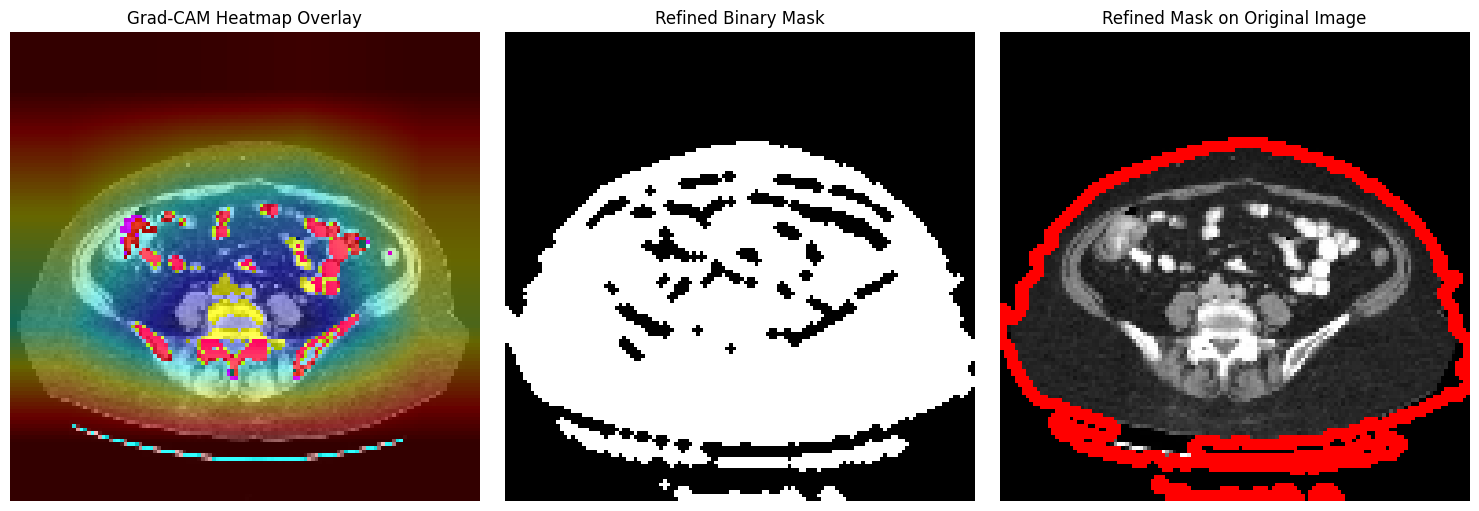

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def overlay_heatmap(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), colormap)
    superimposed_img = heatmap_color * alpha + img
    return np.uint8(superimposed_img)


sample_idx = random.randint(0, len(X_test) - 1)
img = X_test[sample_idx]
img_input = np.expand_dims(cv2.resize(img, (128, 128)), axis=0) / 255.0


heatmap = make_gradcam_heatmap(img_input, classification_model, last_conv_layer_name="top_conv")
heatmap_overlay = overlay_heatmap(cv2.resize(img, (128, 128)), heatmap)


pred_mask = segmentation_model.predict(img_input)[0, :, :, 0]
pred_mask_binary = (pred_mask > 0.5).astype(np.float32)
refined = refine_mask(pred_mask_binary)

def draw_segmentation_contours(image, mask, contour_color=(255, 0, 0), thickness=2):
    mask_uint8 = (mask * 255).astype(np.uint8)
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    image_copy = image.copy()
    image_copy = cv2.resize(image_copy, (128, 128))
    cv2.drawContours(image_copy, contours, -1, contour_color, thickness)
    return image_copy

overlayed_mask = draw_segmentation_contours(img, refined)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(heatmap_overlay)
plt.title("Grad-CAM Heatmap Overlay")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(refined, cmap='gray')
plt.title("Refined Binary Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlayed_mask)
plt.title("Refined Mask on Original Image")
plt.axis("off")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


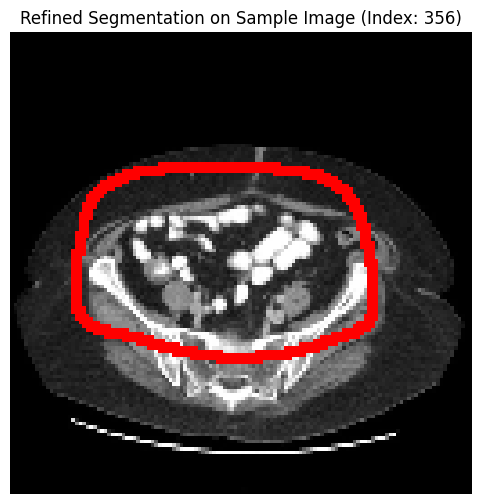

In [ ]:
import random
import matplotlib.pyplot as plt

sample_idx = random.randint(0, len(X_test) - 1)
sample_img = X_test[sample_idx]

resized_img = cv2.resize(sample_img, (128, 128)).astype('float32') / 255.
pred_mask = segmentation_model.predict(np.expand_dims(resized_img, axis=0))
pred_mask = np.squeeze(pred_mask, axis=0)
pred_mask_binary = (pred_mask > 0.5).astype(np.float32)

refined_mask = refine_mask(pred_mask_binary, kernel_size=3)

overlayed_img = draw_segmentation_contours(sample_img, refined_mask, contour_color=(255, 0, 0), thickness=2)

plt.figure(figsize=(6,6))
plt.imshow(overlayed_img)
plt.title(f"Refined Segmentation on Sample Image (Index: {sample_idx})")
plt.axis("off")
plt.show()


Great! accuracy for both train and validation (since the data itself is self defined it is expected)

Unrefined, raw segmentation contours as predicted by the model without any extra processing.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


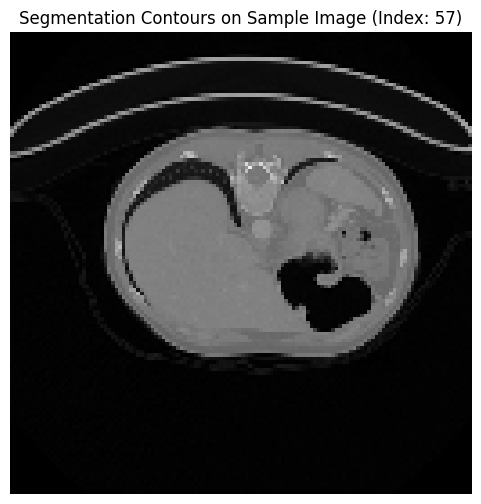

In [ ]:

import random
import matplotlib.pyplot as plt
import cv2

sample_idx = random.randint(0, len(X_test) - 1)
sample_img = X_test[sample_idx]

resized_img = cv2.resize(sample_img, (128, 128)).astype('float32') / 255.
pred_mask = segmentation_model.predict(np.expand_dims(resized_img, axis=0))
pred_mask = np.squeeze(pred_mask, axis=0)
pred_mask_binary = (pred_mask > 0.5).astype(np.float32)

overlayed_img = draw_segmentation_contours(sample_img, pred_mask_binary, contour_color=(255, 0, 0), thickness=2)

plt.figure(figsize=(6,6))
plt.imshow(overlayed_img)
plt.title(f"Segmentation Contours on Sample Image (Index: {sample_idx})")
plt.axis("off")
plt.show()


New try !

In [ ]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git


  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-0j9f6_te
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-0j9f6_te
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp311-cp311-linux_x86_64.whl size=3440330 sha256=29a158749433be208fb812b1b256ad56e6f11eb4dea9f6013f5b28cddb4769bf
  Stored in directory: /tmp/pip-ephem-wheel-cache-ky5tah3a/wheels/ce/8e/34/6dcfa200a9e2ae3627d8009b8bd1ca9b24512bec50a93304de
Successfully built pydensecrf


Use a Combined Loss Function (BCE + Dice Loss) for Training U‑Net

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1 - dice

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce + d_loss

segmentation_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                           loss=combined_loss,
                           metrics=['accuracy'])


segementation model 2 along with Combined loss function

In [ ]:
def unet_model(input_size=(128, 128, 3)):
    from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout
    from tensorflow.keras.models import Model

    inputs = Input(input_size)


    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)


    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)


    up6 = UpSampling2D(size=(2, 2))(drop5)
    up6 = Conv2D(512, 2, activation='relu', padding='same')(up6)
    merge6 = Concatenate()([drop4, up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same')(up7)
    merge7 = Concatenate()([conv3, up7])
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same')(up8)
    merge8 = Concatenate()([conv2, up8])
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same')(up9)
    merge9 = Concatenate()([conv1, up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)


    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    return model

segmentation_model = unet_model(input_size=(128, 128, 3))
segmentation_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                           loss=combined_loss,
                           metrics=['accuracy'])
segmentation_model.summary()


Model: "functional_585"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_23[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_25[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_27[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_28[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_29[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_30[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 8, 8, 512) │          0 │ dropout_3[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ conv2d_31[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 8, 8,      │          0 │ conv2d_32[0][0] 

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_seg = segmentation_model.fit(
    X_train_processed, pseudo_masks,
    validation_split=0.1,
    epochs=20,
    batch_size=8,
    callbacks=[early_stop, lr_reduce]
)


Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 44s 257ms/step - accuracy: 0.8321 - loss: 1.2435 - val_accuracy: 0.8795 - val_loss: 0.7129 - learning_rate: 1.0000e-04
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - accuracy: 0.9137 - loss: 0.6285 - val_accuracy: 0.9241 - val_loss: 0.3776 - learning_rate: 1.0000e-04
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - accuracy: 0.9626 - loss: 0.2818 - val_accuracy: 0.9376 - val_loss: 0.2948 - learning_rate: 1.0000e-04
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - accuracy: 0.9645 - loss: 0.2639 - val_accuracy: 0.9195 - val_loss: 0.4433 - learning_rate: 1.0000e-04
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step - accuracy: 0.9650 - loss: 0.2503 - val_accuracy: 0.9148 - val_loss: 0.3904 - learning_rate: 1.0000e-04
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - accuracy: 0.9657 - loss: 0.2438 - val_accuracy: 0.9262 - val_loss: 0.3447 - learning_rate: 1.0000e-04
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 21s 17

Post-Process the Predicted Segmentation Masks with Morphological Operations

In [ ]:
def refine_mask(mask, kernel_size=3):
    mask_uint8 = (mask * 255).astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

    closed = cv2.morphologyEx(mask_uint8, cv2.MORPH_CLOSE, kernel)

    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)

    refined_mask = (opened.astype(np.float32) / 255.0)
    return refined_mask


Smooth and Threshold the Grad‑CAM Heatmap

In [ ]:
import cv2
import numpy as np

def smooth_and_threshold_heatmap(heatmap, threshold_value=0.7, blur_ksize=(5, 5)):

    heatmap_blurred = cv2.GaussianBlur(heatmap, blur_ksize, 0)
    pseudo_mask = (heatmap_blurred > threshold_value).astype(np.float32)
    return pseudo_mask


In [ ]:
pseudo_mask = smooth_and_threshold_heatmap(heatmap_resized, threshold_value=0.7)


In [ ]:
pred_mask_binary = (pred_mask > 0.5).astype(np.float32)
refined_mask = refine_mask(pred_mask_binary, kernel_size=3)


A CRF can help refine the predicted segmentation boundaries by enforcing consistency with pixel-level features.

In [ ]:
import cv2
import numpy as np
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral

def apply_crf(image, mask_prob, compat=15, iterations=10, threshold=0.5):

    image = image.astype(np.uint8)
    H, W = image.shape[:2]

    probs = np.zeros((2, H, W), dtype=np.float32)
    probs[0] = 1 - mask_prob
    probs[1] = mask_prob

    d = dcrf.DenseCRF2D(W, H, 2)
    U = unary_from_softmax(probs)
    d.setUnaryEnergy(U)

    feats = create_pairwise_bilateral(sdims=(10, 10), schan=(20, 20, 20), img=image, chdim=2)
    d.addPairwiseEnergy(feats, compat=compat)

    Q = d.inference(iterations)
    refined_probs = np.array(Q).reshape((2, H, W))
    tumor_prob_refined = refined_probs[1]

    refined_mask = (tumor_prob_refined > threshold).astype(np.float32)
    return refined_mask


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


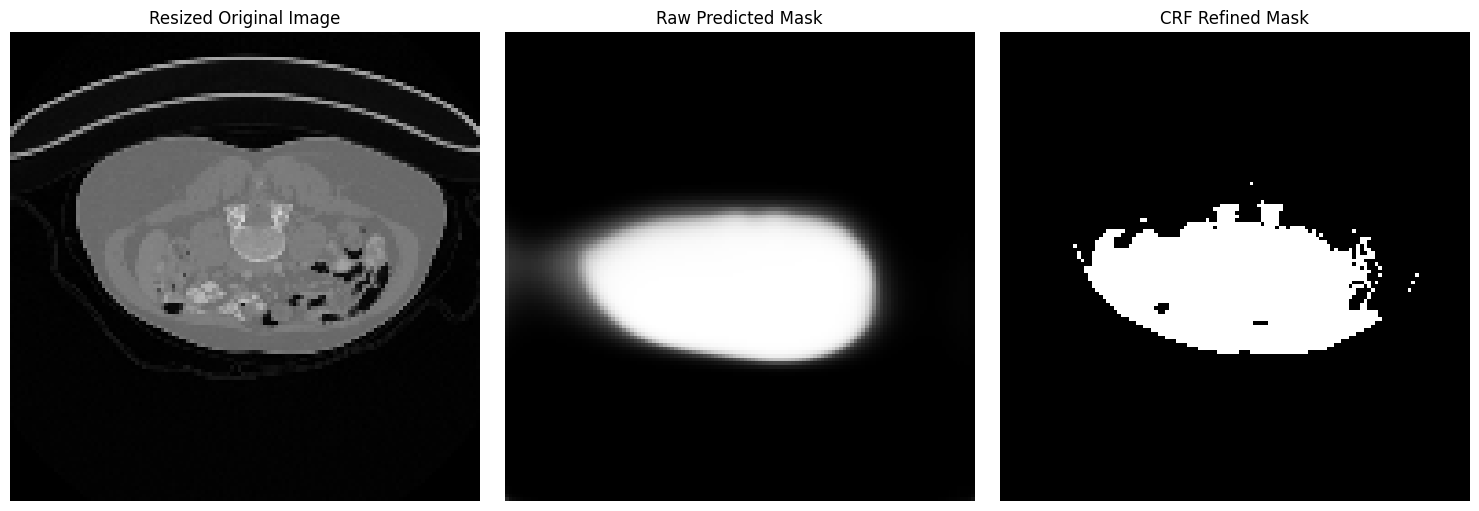

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

sample_idx = random.randint(0, len(X_test) - 1)
orig_img = X_test[sample_idx]

orig_img_resized = cv2.resize(orig_img, (128, 128))
input_img = orig_img_resized.astype('float32') / 255.0
input_batch = np.expand_dims(input_img, axis=0)

pred_mask = segmentation_model.predict(input_batch)
raw_mask = np.squeeze(pred_mask)

crf_refined_mask = apply_crf(orig_img_resized, raw_mask)


plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.imshow(orig_img_resized)
plt.title("Resized Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(raw_mask, cmap='gray')
plt.title("Raw Predicted Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(crf_refined_mask, cmap='gray')
plt.title("CRF Refined Mask")
plt.axis("off")

plt.tight_layout()
plt.show()